In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
import json
import tiktoken
from tqdm import tqdm

### Open the JSON file with the collected data

In [2]:
file_path = 'simple-scraped-kernels-with-sass.json'

# Open and load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

### Let's create a dataframe to store the stats of each kernel

In [8]:
df = pd.DataFrame()
enc = tiktoken.encoding_for_model("gpt-4o-mini")

In [9]:

for target in tqdm(data, desc='Counting tokens'):
    basename = target['basename']
    kernelNames = target['kernelNames']
    for kern in kernelNames:
        statsDict = {'target':[basename], 'kernelName': [kern]}
        kernCtx = target['kernels'][kern]

        sassKeys = list(target['sass'].keys())
        kernSASS = ''
        for key in sassKeys: 
            if kern in key: 
                kernSASS = target['sass'][key]
                break

        #print(kernCtx)
        encoded = enc.encode(kernCtx)
        statsDict['numTokens'] = [len(encoded)]

        encoded = enc.encode(kernSASS)
        statsDict['numTokensSASS'] = [len(encoded)]

        kernDF = pd.DataFrame.from_dict(statsDict).astype({'target': str, 'kernelName': str, 'numTokens': int})
        df = pd.concat([df, kernDF], ignore_index=True)




Counting tokens: 100%|██████████| 749/749 [00:55<00:00, 13.55it/s]


In [10]:
# let's check our dataframe
print(df.shape)
print(df.head(10))

cudaDF = df[df['target'].str.contains('-cuda')]
cudaDF = cudaDF.sort_values(by=['numTokens', 'numTokensSASS'], ascending=True, ignore_index=True)

ompDF = df[df['target'].str.contains('-omp')]
ompDF = ompDF.sort_values(by=['numTokens', 'numTokensSASS'], ascending=True, ignore_index=True)

# this is cost in USD
costPer1e6Tokens = 0.15

# add some stats to the dataset
cudaDF['totalSumTokens'] = cudaDF['numTokens'].cumsum()
cudaDF['totalInfCost'] = costPer1e6Tokens*(cudaDF['totalSumTokens']/1e6)

cudaDF['totalSumTokensSASS'] = cudaDF['numTokensSASS'].cumsum()
cudaDF['totalInfCostSASS'] = costPer1e6Tokens*(cudaDF['totalSumTokensSASS']/1e6)

ompDF['totalSumTokens'] = ompDF['numTokens'].cumsum()
ompDF['totalInfCost'] = costPer1e6Tokens*(ompDF['totalSumTokens']/1e6)

ompDF['totalSumTokensSASS'] = ompDF['numTokensSASS'].cumsum()
ompDF['totalInfCostSASS'] = costPer1e6Tokens*(ompDF['totalSumTokensSASS']/1e6)

print(cudaDF.shape)
print(cudaDF.head(10))
print()
print()
print(ompDF.shape)
print(ompDF.head(10))

(2171, 4)
          target                                         kernelName  \
0  accuracy-cuda                                    accuracy_kernel   
1   accuracy-omp            __omp_offloading_10309_2f04138_main_l57   
2       ace-cuda                                boundaryConditionsU   
3       ace-cuda                                           swapGrid   
4       ace-cuda                                     calculateForce   
5       ace-cuda                              boundaryConditionsPhi   
6       ace-cuda                                    thermalEquation   
7       ace-cuda                                          allenCahn   
8        ace-omp  __omp_offloading_10309_2f0414b__Z9allenCahnPA4...   
9        ace-omp  __omp_offloading_10309_2f0414b__Z15thermalEqua...   

   numTokens  numTokensSASS  
0       1154           5262  
1        764          15454  
2       7879           3511  
3       7879           1853  
4       7879          22683  
5       7879           3446 

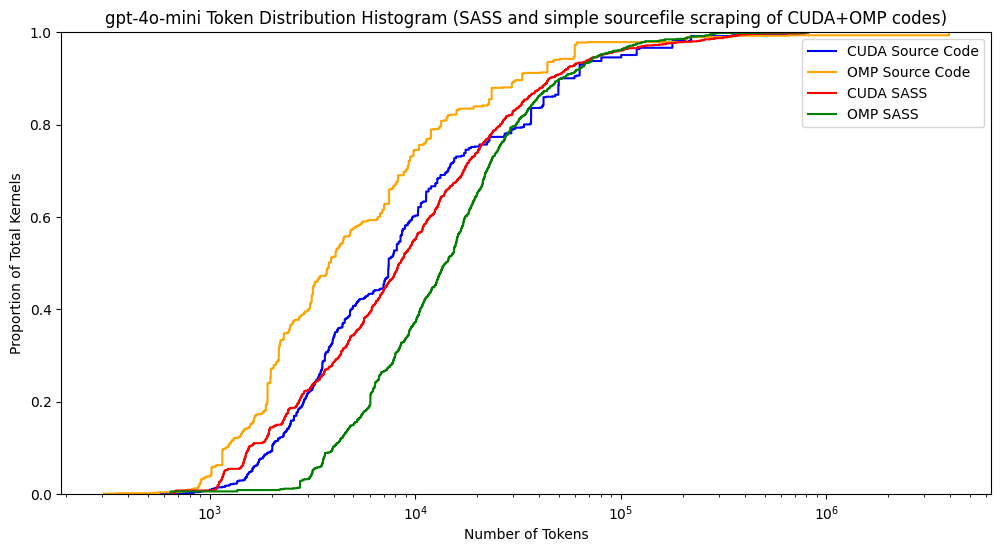

In [24]:

fig, ax = plt.subplots(1, figsize=(12,6))


#sns.histplot(cudaDF, x='numTokens', bins=300, ax=ax, log_scale=True, color='blue')
#sns.histplot(ompDF, x='numTokens', bins=300, ax=ax, log_scale=True, color='orange')
#sns.histplot(cudaDF, x='numTokensSASS', bins=300, ax=ax, log_scale=True, color='red')
#sns.histplot(ompDF, x='numTokensSASS', bins=300, ax=ax, log_scale=True, color='green')
#ax2 = ax.twinx()
ax2 = ax
sns.ecdfplot(cudaDF, x='numTokens', ax=ax2, log_scale=True, color='blue')
sns.ecdfplot(ompDF, x='numTokens', ax=ax2, log_scale=True, color='orange')
sns.ecdfplot(cudaDF, x='numTokensSASS', ax=ax2, log_scale=True, color='red')
sns.ecdfplot(ompDF, x='numTokensSASS', ax=ax2, log_scale=True, color='green')

ax.set_xlabel('Number of Tokens')
#ax.set_ylabel('Number of Kernels')
ax.set_ylabel('')
ax2.set_ylabel('Proportion of Total Kernels')

ax.legend(['CUDA Source Code', 'OMP Source Code', 'CUDA SASS', 'OMP SASS'])

ax.set_title('gpt-4o-mini Token Distribution Histogram (SASS and simple sourcefile scraping of CUDA+OMP codes)')

plt.show()


### Expected Cost Analysis

In [7]:
# sort the dataframe by token count


In [17]:

# given a sorted dataframe
def getNumTokensCDF(df, percent, column='numTokens'):
    subDF = df.sort_values(by=[column]).reset_index(drop=True)
    numRows = subDF.shape[0]
    # map the percent to the numRows range
    idx = int(percent * (numRows-1))
    numTokens = subDF.iloc[idx][column]
    return numTokens

def getNumSamplesLTETokenCount(df, tokCount, column='numTokens'):
    subset = df[df[column] <= tokCount]
    return subset.shape[0]

In [18]:
percents = [0.1, 0.25, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]

for perc in percents:
    print(f'  CUDA {int(100*perc)}% of samples have token count <= {getNumTokensCDF(cudaDF, perc)} tokens ({getNumSamplesLTETokenCount(cudaDF, getNumTokensCDF(cudaDF, perc))} samples)')
    print(f'OPENMP {int(100*perc)}% of samples have token count <= {getNumTokensCDF(ompDF, perc)} tokens ({getNumSamplesLTETokenCount(ompDF, getNumTokensCDF(ompDF, perc))} samples)')
    print()

print(f'  CUDA Num samples with less than 25k tokens: {getNumSamplesLTETokenCount(cudaDF, 25000)}')
print(f'OPENMP Num samples with less than 25k tokens: {getNumSamplesLTETokenCount(ompDF, 25000)}')

  CUDA 10% of samples have token count <= 2012 tokens (117 samples)
OPENMP 10% of samples have token count <= 1195 tokens (102 samples)

  CUDA 25% of samples have token count <= 3351 tokens (288 samples)
OPENMP 25% of samples have token count <= 1971 tokens (255 samples)

  CUDA 50% of samples have token count <= 7419 tokens (587 samples)
OPENMP 50% of samples have token count <= 3797 tokens (511 samples)

  CUDA 60% of samples have token count <= 9738 tokens (692 samples)
OPENMP 60% of samples have token count <= 6570 tokens (612 samples)

  CUDA 65% of samples have token count <= 11288 tokens (754 samples)
OPENMP 65% of samples have token count <= 7452 tokens (673 samples)

  CUDA 70% of samples have token count <= 14448 tokens (809 samples)
OPENMP 70% of samples have token count <= 9007 tokens (716 samples)

  CUDA 75% of samples have token count <= 18670 tokens (865 samples)
OPENMP 75% of samples have token count <= 10423 tokens (771 samples)

  CUDA 80% of samples have token coun

In [19]:
for perc in percents:
    print(f'  CUDA {int(100*perc)}% of SASS samples have token count <= {getNumTokensCDF(cudaDF, perc, "numTokensSASS")} tokens ({getNumSamplesLTETokenCount(cudaDF, getNumTokensCDF(cudaDF, perc, "numTokensSASS"), "numTokensSASS")} samples)')
    print(f'OPENMP {int(100*perc)}% of SASS samples have token count <= {getNumTokensCDF(ompDF, perc, "numTokensSASS")} tokens ({getNumSamplesLTETokenCount(ompDF, getNumTokensCDF(ompDF, perc, "numTokensSASS"), "numTokensSASS")} samples)')
    print()

print(f'  CUDA Num SASS samples with less than 25k tokens: {getNumSamplesLTETokenCount(cudaDF, 25000, "numTokensSASS")}')
print(f'OPENMP Num SASS samples with less than 25k tokens: {getNumSamplesLTETokenCount(ompDF, 25000, "numTokensSASS")}')

  CUDA 10% of SASS samples have token count <= 1548 tokens (118 samples)
OPENMP 10% of SASS samples have token count <= 3970 tokens (102 samples)

  CUDA 25% of SASS samples have token count <= 3426 tokens (289 samples)
OPENMP 25% of SASS samples have token count <= 6636 tokens (256 samples)

  CUDA 50% of SASS samples have token count <= 8416 tokens (576 samples)
OPENMP 50% of SASS samples have token count <= 14048 tokens (510 samples)

  CUDA 60% of SASS samples have token count <= 11774 tokens (691 samples)
OPENMP 60% of SASS samples have token count <= 17414 tokens (612 samples)

  CUDA 65% of SASS samples have token count <= 13854 tokens (748 samples)
OPENMP 65% of SASS samples have token count <= 19956 tokens (663 samples)

  CUDA 70% of SASS samples have token count <= 17195 tokens (806 samples)
OPENMP 70% of SASS samples have token count <= 22264 tokens (714 samples)

  CUDA 75% of SASS samples have token count <= 20566 tokens (863 samples)
OPENMP 75% of SASS samples have token

In [25]:

def calcMinCostOfInferenceForPercentOfDF(df, percent, column='numTokens'):
    subDF = df.sort_values(by=[column]).reset_index(drop=True)
    numRows = subDF.shape[0]
    # map the percent to the numRows range
    idx = int(percent * (numRows-1))

    subset = subDF.iloc[0:idx+1]

    totalNumTokens = subset[column].sum()

    cost = costPer1e6Tokens * (totalNumTokens/1e6)

    return cost
    


In [26]:

for perc in percents:
    print(f'  CUDA Min expected cost to inference smallest {int(100*perc)}% of dataset: ${round(calcMinCostOfInferenceForPercentOfDF(cudaDF, perc),4)}')
    print(f'OPENMP Min expected cost to inference smallest {int(100*perc)}% of dataset: ${round(calcMinCostOfInferenceForPercentOfDF(ompDF, perc),4)}')
    print()

  CUDA Min expected cost to inference smallest 10% of dataset: $0.0267
OPENMP Min expected cost to inference smallest 10% of dataset: $0.0153

  CUDA Min expected cost to inference smallest 25% of dataset: $0.0955
OPENMP Min expected cost to inference smallest 25% of dataset: $0.054

  CUDA Min expected cost to inference smallest 50% of dataset: $0.3114
OPENMP Min expected cost to inference smallest 50% of dataset: $0.158

  CUDA Min expected cost to inference smallest 60% of dataset: $0.4568
OPENMP Min expected cost to inference smallest 60% of dataset: $0.2296

  CUDA Min expected cost to inference smallest 65% of dataset: $0.5483
OPENMP Min expected cost to inference smallest 65% of dataset: $0.2843

  CUDA Min expected cost to inference smallest 70% of dataset: $0.6586
OPENMP Min expected cost to inference smallest 70% of dataset: $0.3463

  CUDA Min expected cost to inference smallest 75% of dataset: $0.7956
OPENMP Min expected cost to inference smallest 75% of dataset: $0.4192

 

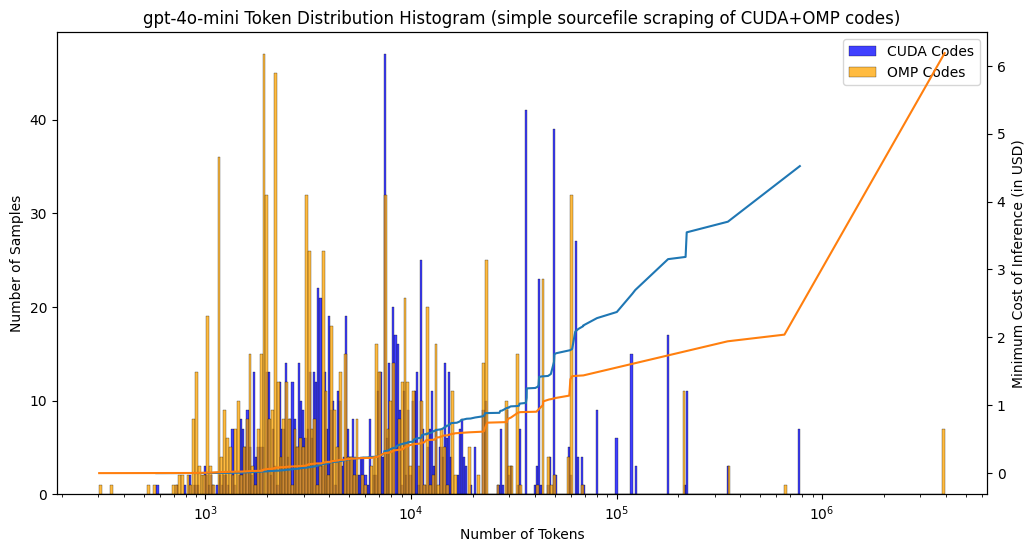

In [27]:
fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(cudaDF, x='numTokens', bins=300, ax=ax, log_scale=True, color='blue')
sns.histplot(ompDF, x='numTokens', bins=300, ax=ax, log_scale=True, color='orange')
ax2 = ax.twinx()
sns.lineplot(cudaDF.groupby(['numTokens'])['totalInfCost'].max().reset_index().sort_values(by=['numTokens'], ascending=True, ignore_index=True), x='numTokens', y='totalInfCost', ax=ax2)
sns.lineplot(ompDF.groupby(['numTokens'])['totalInfCost'].max().reset_index().sort_values(by=['numTokens'], ascending=True, ignore_index=True), x='numTokens', y='totalInfCost', ax=ax2)

ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Number of Samples')
ax2.set_ylabel('Minimum Cost of Inference (in USD)')

ax.legend(['CUDA Codes', 'OMP Codes'])

ax.set_title('gpt-4o-mini Token Distribution Histogram (simple sourcefile scraping of CUDA+OMP codes)')

plt.show()

### Pruning the Dataset

In [13]:
def savePercentOfDF(df, percent, outfile):
    numRows = df.shape[0]
    # map the percent to the numRows range
    idx = int(percent * (numRows-1))

    subset = df.iloc[0:idx+1]

    targetNames = list(subset['target'].unique())

    subset = df[df['target'].isin(targetNames)]

    tosave = []

    for target in tqdm(data, desc='Gathering targets to export'):
        basename = target['basename']
        if basename in targetNames:
            tosave.append(target)

    with open(outfile, 'w') as fp:
        json.dump(tosave, fp, indent=4)

    print(f'Expected min inference cost: ${round(subset.iloc[subset.shape[0]-1]["totalInfCost"], 3)} for {outfile}')
    print(f'Num kernels: {subset.shape[0]} for {outfile}')
    print()


def saveMaxTokenCountOfDF(df, maxTokens, outfile):
    subset = df[df['numTokens'] <= maxTokens]

    targetNames = list(subset['target'].unique())

    subset = df[df['target'].isin(targetNames)]

    tosave = []

    for target in data:
        basename = target['basename']
        if basename in targetNames:
            tosave.append(target)

    with open(outfile, 'w') as fp:
        json.dump(tosave, fp, indent=4)

    print(f'Expected min inference cost: ${round(subset.iloc[subset.shape[0]-1]["totalInfCost"], 3)} for {outfile}')
    print(f'Num kernels: {subset.shape[0]} for {outfile}')
    print()




In [14]:
#savePercentOfDF(cudaDF, 0.65, 'simple-scraped-kernels-CUDA-pruned.json')
#savePercentOfDF(ompDF, 0.65, 'simple-scraped-kernels-OMP-pruned.json')

#saveMaxTokenCountOfDF(cudaDF, 7452, '../dataset-gen/simple-scraped-kernels-CUDA-pruned.json')
#saveMaxTokenCountOfDF(ompDF, 7452, '../dataset-gen/simple-scraped-kernels-OMP-pruned.json')

In [15]:
saveMaxTokenCountOfDF(cudaDF, 8e3, '../dataset-gen/simple-scraped-kernels-CUDA-pruned-with-sass.json')
saveMaxTokenCountOfDF(ompDF, 8e3, '../dataset-gen/simple-scraped-kernels-OMP-pruned-with-sass.json')

Expected min inference cost: $0.347 for ../dataset-gen/simple-scraped-kernels-CUDA-pruned-with-sass.json
Num kernels: 607 for ../dataset-gen/simple-scraped-kernels-CUDA-pruned-with-sass.json

Expected min inference cost: $0.308 for ../dataset-gen/simple-scraped-kernels-OMP-pruned-with-sass.json
Num kernels: 684 for ../dataset-gen/simple-scraped-kernels-OMP-pruned-with-sass.json

